**Importing Modules**

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
import h5py

**Importing train and test datasets**

In [62]:

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = train.flow_from_directory("E:/vscode/archive/Face Mask Dataset/Train/",
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("E:/vscode/archive/Face Mask Dataset/Test/",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


**check your encoded class labels**

In [75]:
test_dataset.class_indices

{'WithMask': 0, 'WithoutMask': 1}

**Defining our CNN Model Layers**

In [64]:

model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for No mask or 1 for Mask
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

*Specifying Optimizers and loss functions*

In [65]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

**Training the Model**

In [74]:

#steps_per_epoch = train_imagesize/batch_size

model.fit_generator(train_dataset,
         steps_per_epoch = 250,
         epochs = 10,
         validation_data = test_dataset
       
         )

Epoch 1/10
250/250 [==============================] - 15s 59ms/step - loss: 0.0104 - accuracy: 0.9959 - val_loss: 0.0832 - val_accuracy: 0.9778
Epoch 2/10
250/250 [==============================] - 16s 63ms/step - loss: 0.0223 - accuracy: 0.9931 - val_loss: 0.0345 - val_accuracy: 0.9929
Epoch 3/10
250/250 [==============================] - 15s 61ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0361 - val_accuracy: 0.9899
Epoch 4/10
250/250 [==============================] - 14s 55ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0724 - val_accuracy: 0.9819
Epoch 5/10
250/250 [==============================] - 15s 60ms/step - loss: 0.0106 - accuracy: 0.9962 - val_loss: 0.0396 - val_accuracy: 0.9859
Epoch 6/10
250/250 [==============================] - 13s 51ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0387 - val_accuracy: 0.9909
Epoch 7/10
250/250 [==============================] - 14s 55ms/step - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0525 - val_accuracy:

*saving our model for instant access*

In [67]:
model.save('mask_detection.h5',model)

**Mask detection for indidual pictures**

In [4]:

def predict(filenamepath):
    mask_detection = load_model('mask_detection.h5')
    
    img1=image.load_img(filenamepath, target_size=(150,150,3))
    plt.imshow(img1)
    img1=image.img_to_array(img1)
    img1=np.expand_dims(img1,axis=0)
    value=mask_detection.predict(img1)
    print(int(value))
    if value == 1:
        
        plt.xlabel("Mask",fontsize=30)
        
    
    elif value == 0:
        
        plt.xlabel("no mask",fontsize=30)

0


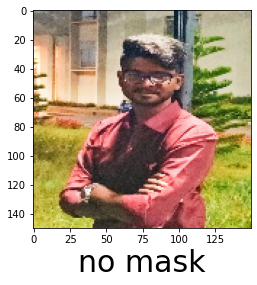

In [5]:
predict('E:/vscode/g.jpg')

**Mask Detection for live camera feed**

In [2]:
from keras.models import Sequential,load_model
import os
import cv2
mask_detection=load_model('mask_detection.h5')

faceCascade = cv2.CascadeClassifier('E:/vscode/xmls/haarcascade_frontalface_alt2.xml')

video_capture = cv2.VideoCapture(0)
while True: #(or 1)
    # Capture frame-by-frame
    
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(frame,
                                         scaleFactor=1.02,
                                         minNeighbors=5,
                                         minSize=(30, 30),
                                         flags=cv2.CASCADE_SCALE_IMAGE)

    for (x,y,w,h) in faces:
        face_frame = frame[y:y+h,x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        cv2.imwrite('temp.jpg', face_frame)
        X = image.load_img('temp.jpg', target_size=(150,150,3))
        X = image.img_to_array(X)
        Z = np.expand_dims(X,axis=0)
        val1 = mask_detection.predict(Z)
        
        if int(val1) == 0:
            cv2.rectangle(frame, (x, y), (x + w, y + h),(0,255,0), 3)
            cv2.putText(frame,'Mask',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),3)
        if int(val1) == 1:
            cv2.rectangle(frame, (x, y), (x + w, y + h),(0,0,255), 3)
            cv2.putText(frame,'No mask',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),3)

        cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()